In [1]:
# Install required libraries.
# Acknowledge and proceed if a dependency conflict warning for `fsspec` is displayed;
# the installed version is crucial for HuggingFace compatibility.

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

# Load the data from hugging face

Dataset used in this project contains Amazon product descriptions paired with their corresponding prices. It includes detailed product information from a variety of categories, providing text descriptions and pricing data ideal for training and evaluating price prediction models based on natural language product content.

https://huggingface.co/datasets/ed-donner/pricer-data/viewer/default/train?views%5B%5D=train

In [4]:
DATASET_NAME = "ed-donner/pricer-data"
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/914k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Prepare the finetuned `Llama-3.1-8b` model for evaluation

## download the finetuned model saved to hugging face

In [7]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
FINETUNED_MODEL = "omkarbare/amazon-pricing-model-finetuned"

QUANT_4_BIT = True

In [8]:
# Configure quantization settings based on QUANT_4_BIT flag.

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [9]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [10]:
# Load the fine-tuned model with PEFT
fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

adapter_config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

In [11]:
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Memory footprint: 5700.6 MB


# Helper functions for evaluation
same  functions used for evaluation of base model: https://colab.research.google.com/drive/1CRi9VZB5tvsyb45Zd76Qi83zWruVsXvn?usp=sharing

In [12]:
def extract_price(s):
    """
    Extracts the first numeric price value from a given string.

    The function looks for the pattern "Price is $" in the input string,
    then extracts and returns the first floating-point or integer number
    following that pattern. The extracted numeric string may contain commas
    which are removed before conversion. If no valid number is found,
    the function returns 0.

    Args:
        s (str): Input string potentially containing a price.

    Returns:
        float: Extracted price value as a float. Returns 0 if no price found.

    Example:
        extract_price("The Price is $1,234.56 for this item") returns 1234.56
    """

    # Check if the input string contains the expected price prefix
    if "Price is $" in s:

        # Split string to get the part after "Price is $"
        contents = s.split("Price is $", 1)[1]

        # Remove commas and dollar sign if present in the substring
        contents = contents.replace(',', '').replace('$', '')

        # Use regex to find the first number (int or float) in the cleaned string
        match = re.search(r"[-+]?\d*\.\d+|\d+", contents)

        # Return the float value if match is found, otherwise 0
        return float(match.group()) if match else 0

    # Return 0 if "Price is $" pattern does not exist
    return 0


In [13]:
def model_predict(prompt):
    """
    Generates a prediction from the base language model given an input prompt,
    then extracts and returns a price value from the model's response.

    The function sets a fixed random seed for reproducibility, tokenizes the input
    prompt, performs generation on the GPU with attention masking, decodes the
    generated tokens back to text, and extracts a numeric price from the generated text.

    Args:
        prompt (str): Input text prompt for the language model.

    Returns:
        float: Extracted price from the model's generated response using extract_price().

    Notes:
        - Assumes that `tokenizer`, `base_model`, and `extract_price` are
          defined and accessible in the same scope.
        - Sets a fixed seed (42) to ensure reproducible outputs.
        - Uses a generation limit of 4 new tokens for controlled output length.
        - Uses CUDA device for faster tensor operations if available.
    """
    # Fix the random seed for reproducibility of results
    set_seed(42)

    # Encode the input prompt into token IDs and move tensors to CUDA device
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")

    # Create attention mask of ones with the same shape as input tokens on CUDA device
    attention_mask = torch.ones(inputs.shape, device="cuda")

    # Generate model outputs, limiting the generation length to 4 tokens
    outputs = base_model.generate(
        inputs,
        max_new_tokens=4,
        attention_mask=attention_mask,
        num_return_sequences=1
    )

    # Decode the generated token IDs back to string form
    response = tokenizer.decode(outputs[0])

    # Extract and return the price value from the generated response text
    return extract_price(response)


In [14]:
# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [15]:
# tester class
class Tester:
    """
    A utility class to evaluate and visualize the performance of a prediction model.

    This class runs the predictor function against a dataset, calculates error metrics,
    assigns color-coded performance categories, and provides a summary report along
    with a scatter plot comparing ground truth prices to model estimates.

    Attributes:
        predictor (callable): A function that takes input text and returns a predicted price.
        data (list): Dataset of dictionaries with keys 'text' and 'price'.
        title (str): Optional descriptive title for the test, derived from predictor if not provided.
        size (int): Number of data points to evaluate (default 250).
        guesses (list): Stores predictor outputs for each datapoint.
        truths (list): Stores actual ground truth prices.
        errors (list): Absolute error between guess and truth.
        sles (list): Squared logarithmic errors (SLE) for more robust error measure.
        colors (list): Color labels ('green', 'orange', 'red') representing error magnitude.
    """

    def __init__(self, predictor, data, title=None, size=250):
        """Initializes the Tester with model predictor, data, optional title and evaluation size."""
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        """
        Determines a color label based on the error magnitude relative to the truth value.

        Args:
            error (float): Absolute difference between prediction and ground truth.
            truth (float): Ground truth price value.

        Returns:
            str: "green" for low errors,
                 "orange" for moderate errors,
                 "red" for high errors.
        """
        if error < 40 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        """
        Runs prediction and error calculation on a single datapoint, stores the results,
        and prints a color-coded summary line.

        Args:
            i (int): Index of the datapoint in the dataset.
        """
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        # Extract a shortened snippet from the text for display
        title = datapoint["text"].split("\n\n")[1][:20] + "..." if "\n\n" in datapoint["text"] else datapoint["text"][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i + 1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        """
        Generates a scatter plot comparing ground truth prices and model predictions.
        A diagonal reference line is added for perfect prediction.

        Args:
            title (str): Title to display on the plot.
        """
        max_val = max(max(self.truths), max(self.guesses))
        plt.figure(figsize=(12, 8))
        # Diagonal line of perfect predictions for reference
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        # Scatter plot with colors indicating error magnitude
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        """
        Computes aggregate error metrics and generates a summary report
        with a visualization of performance.
        """
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(color == "green" for color in self.colors)
        title = (
            f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} "
            f"Hits={hits / self.size * 100:.1f}%"
        )
        self.chart(title)

    def run(self):
        """
        Executes the full evaluation running all datapoints and generating the final report.
        """
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        """
        Convenience class method for quickly running tests without manual instantiation.

        Args:
            function (callable): Predictor function to evaluate.
            data (list): Dataset of input dictionaries with 'text' and 'price'.
        """
        cls(function, data).run()


# Evaluation

1: Guess: $317.00 Truth: $374.41 Error: $57.41 SLE: 0.03 Item: OEM AC Compressor w/...
2: Guess: $182.00 Truth: $225.11 Error: $43.11 SLE: 0.04 Item: Motorcraft YB3125 Fa...
3: Guess: $31.00 Truth: $61.68 Error: $30.68 SLE: 0.45 Item: Dorman Front Washer ...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium HD Plus T...
5: Guess: $19.00 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: Super Switch Pickup ...
6: Guess: $19.00 Truth: $31.99 Error: $12.99 SLE: 0.25 Item: Horror Bookmarks, Re...
7: Guess: $133.00 Truth: $101.79 Error: $31.21 SLE: 0.07 Item: SK6241 - Stinger 4 G...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $950.00 Truth: $635.86 Error: $314.14 SLE: 0.16 Item: Randall G3 Plus Comb...
10: Guess: $66.00 Truth: $65.99 Error: $0.01 SLE: 0.00 Item: HOLDWILL 6 Pack LED ...
11: Guess: $189.00 Truth: $254.21 Error: $65.21 SLE: 0.09 Item: Viking Horns 3 Gallo...
12: Guess: $379.00 Truth: $412.99 Error: $33.99 S

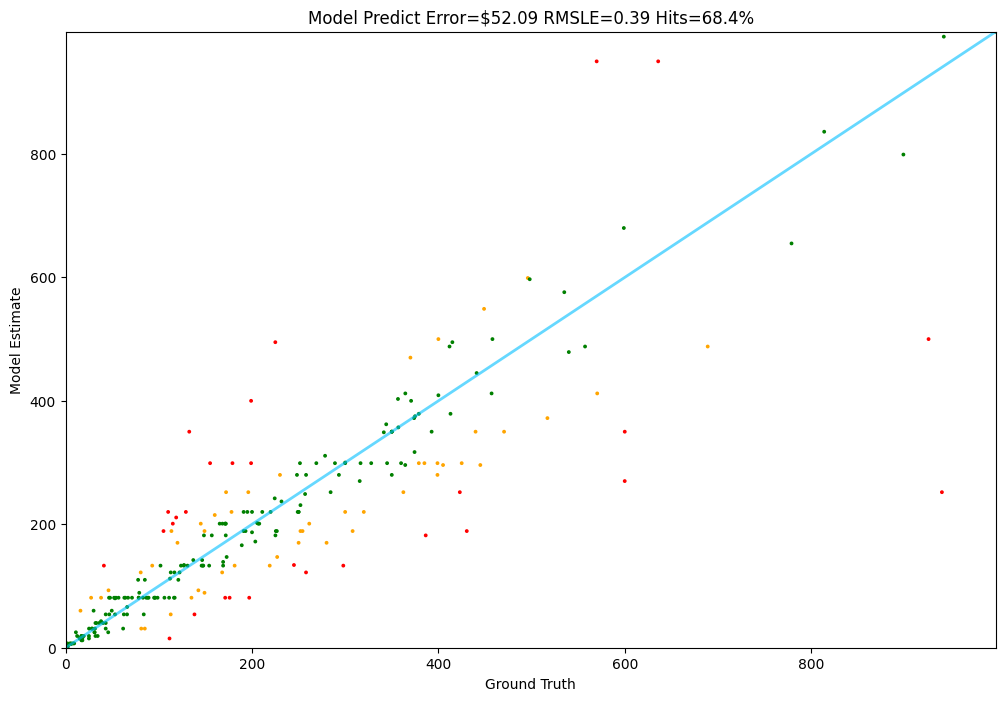

In [16]:
Tester.test(model_predict, test)

# Result

Evaluation of base model is done in this notebook: https://colab.research.google.com/drive/1CRi9VZB5tvsyb45Zd76Qi83zWruVsXvn?usp=sharing

Compared to base model prediction:
1. The predict error dropped dramatically from $395.72 to $52.09, indicating predictions are now much closer to the actual values.​

2. RMSLE fell from 1.49 to 0.39, showing the model's logarithmic accuracy has improved substantially.​

3. The hit rate increased from 28% to 68.4%, meaning more predictions now fall within an acceptable error range.​

4. Visual inspection shows the scatter is more tightly clustered along the diagonal, denoting much better calibration and reduced systematic bias.

- The finetuned Llama 3.1-8b model for this particular task is significantly more accurate, less prone to extreme errors, and much better aligned with ground truth values compared to the base model.